In [62]:
import pypsa, pandas as pd

In [2]:
n = pypsa.Network("networks/230405-10a-UK-test/UK-10a-H2u.nc")

INFO:pypsa.io:Imported network UK-10a-H2u.nc has buses, generators, links, loads, stores


# Check revenues cover costs

In [3]:
elec_mv_electrolyser = (n.buses_t.marginal_price["electricity"]*n.links_t.p0["hydrogen_electrolyser"]).sum()/n.links_t.p0["hydrogen_electrolyser"].sum()
elec_mv_electrolyser

14.667049087040738

In [4]:
h2_mv_electrolyser = (n.buses_t.marginal_price["hydrogen"]*n.links_t.p1["hydrogen_electrolyser"]).sum()/n.links_t.p1["hydrogen_electrolyser"].sum()
h2_mv_electrolyser

39.81941460136643

In [5]:
#per MWh_H2 contribution of electrolyser cost
total_cost = (n.links.at["hydrogen_electrolyser","p_nom_opt"]*n.links.at["hydrogen_electrolyser","capital_cost"])
elec_capex_part = total_cost/(-3*n.links_t.p1["hydrogen_electrolyser"]).sum()
elec_capex_part

18.283331678827754

In [6]:
elec_mv_electrolyser/n.links.at["hydrogen_electrolyser","efficiency"] + elec_capex_part

39.85252151271119

In [7]:
elec_mv_turbine = (n.buses_t.marginal_price["electricity"]*n.links_t.p1["hydrogen_turbine"]).sum()/n.links_t.p1["hydrogen_turbine"].sum()
elec_mv_turbine

200.56638782935624

In [8]:
h2_mv_turbine = (n.buses_t.marginal_price["hydrogen"]*n.links_t.p0["hydrogen_turbine"]).sum()/n.links_t.p0["hydrogen_turbine"].sum()
h2_mv_turbine

80.88998238569656

In [9]:
#per MWh_H2 contribution of turbine cost
total_cost = (n.links.at["hydrogen_turbine","p_nom_opt"]*n.links.at["hydrogen_turbine","capital_cost"])
turbine_capex_part = total_cost/(-3*n.links_t.p1["hydrogen_turbine"]).sum()
turbine_capex_part

61.159387887722545

In [10]:
turbine_capex_part + h2_mv_turbine/n.links.at["hydrogen_turbine","efficiency"]

200.62487475961316

In [11]:
#turbine pays for H2
(3*n.buses_t.marginal_price["hydrogen"]*n.links_t.p0["hydrogen_turbine"]).sum()/1e6

170.57552626305227

In [12]:
#electrolyser sells H2
(-3*n.buses_t.marginal_price["hydrogen"]*n.links_t.p1["hydrogen_electrolyser"]).sum()/1e6

83.96858428825237

In [13]:
# also there are costs for compressor
n.stores.e_nom_opt*n.stores.capital_cost/1e6

Store
battery_energy     34.506414
hydrogen_energy    75.007293
dtype: float64

In [14]:
n.links

,bus0,bus1,carrier,efficiency,p_nom_extendable,capital_cost,p_nom_opt,bus2,efficiency2,type,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
battery_power,electricity,battery,battery inverter,0.979796,True,234842.383964,38.609036,,1.00,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
battery_discharge,battery,electricity,battery discharger,0.979796,True,0.000000,39.405178,,1.00,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
hydrogen_electrolyser,electricity,hydrogen,hydrogen electrolyser,0.680000,True,422535.529479,91.246048,,1.00,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
hydrogen_compressor,hydrogen,compressed hydrogen,hydrogen storing compressor,1.000000,True,119572.186233,62.048115,electricity,-0.12,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
hydrogen_decompressor,compressed hydrogen,hydrogen,hydrogen storing decompressor,1.000000,True,0.000000,143.691255,,1.00,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
hydrogen_turbine,hydrogen,electricity,hydrogen turbine,0.580000,True,555177.344840,134.735292,,1.00,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


# Check distribution of LCOE into MVs

In [101]:
ts = pd.concat([(-1)**i*n.links_t["p"+str(i)][n.links.index[n.links["bus"+str(i)].map(n.buses.carrier) == "electricity"]] for i in range(3)],
         axis=1)
ts["vre_direct"] = vre_direct = n.loads_t.p["load"] + n.links_t.p1[["battery_discharge","hydrogen_turbine"]].sum(axis=1)
ts["vre"] = n.generators_t.p[["wind","solar"]].sum(axis=1)
ts["load"] = n.loads_t.p["load"]
ts

Link,battery_power,hydrogen_electrolyser,battery_discharge,hydrogen_turbine,hydrogen_compressor,vre_direct,vre,load
snapshot,,,,,,,,
2011-01-01 00:00:00,3.621624,0.213172,3.898406,18.239599,0.095714,77.861996,81.792507,100.0
2011-01-01 03:00:00,3.326916,0.214600,4.220489,28.553928,0.100032,67.225583,70.867132,100.0
2011-01-01 06:00:00,3.347008,0.216063,4.222163,30.433456,0.101546,65.344381,69.008998,100.0
2011-01-01 09:00:00,3.303005,0.218443,4.398936,42.313012,0.104525,53.288052,56.914028,100.0
2011-01-01 12:00:00,3.215352,0.217564,4.320761,30.650321,0.099377,65.028918,68.561215,100.0
...,...,...,...,...,...,...,...,...
2020-12-31 09:00:00,2.907536,0.219242,5.092447,40.908747,0.106672,53.998807,57.232261,100.0
2020-12-31 12:00:00,20.881291,0.220088,2.220472,5.982246,0.097129,91.797282,112.995794,100.0
2020-12-31 15:00:00,4.987962,0.214448,2.893466,10.725401,0.098508,86.381133,91.682056,100.0


count    29224.000000
mean        72.122992
std         27.192297
min         -4.128357
25%         55.994345
50%         84.040413
75%         93.046821
max         99.999818
Name: vre_direct, dtype: float64


<AxesSubplot: xlabel='snapshot'>

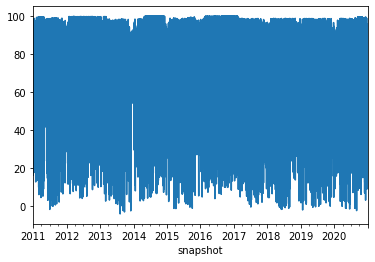

In [102]:
print(ts["vre_direct"].describe())
ts["vre_direct"].plot()

In [103]:
mvs = ts.multiply(n.buses_t.marginal_price["electricity"],axis=0).sum()/ts.sum()
mvs

Link
battery_power             17.740569
hydrogen_electrolyser     14.667049
battery_discharge         54.026280
hydrogen_turbine         200.566388
hydrogen_compressor       13.704262
vre_direct                54.484428
vre                       37.954248
load                      74.799754
dtype: float64

In [104]:
frac = ts.sum()/ts["load"].sum()
frac

Link
battery_power            0.145068
hydrogen_electrolyser    0.353714
battery_discharge        0.139265
hydrogen_turbine         0.139505
hydrogen_compressor      0.031039
vre_direct               0.721230
vre                      1.251051
load                     1.000000
dtype: float64

In [105]:
gens = ['vre_direct', 'battery_discharge', 'hydrogen_turbine']
frac[gens].sum()

1.0000000000000002

In [106]:
(frac[gens]*mvs[gens]).sum()

74.79975389378293

In [108]:
chargers = ["battery_power","hydrogen_electrolyser","hydrogen_compressor"]
frac[chargers].sum()+frac["vre_direct"]

1.2510509216879342

In [111]:
gen_frac = ts.sum()/ts["vre"].sum()
gen_frac

Link
battery_power            0.115957
hydrogen_electrolyser    0.282733
battery_discharge        0.111319
hydrogen_turbine         0.111510
hydrogen_compressor      0.024810
vre_direct               0.576499
vre                      1.000000
load                     0.799328
dtype: float64

In [112]:
(gen_frac[chargers]*mvs[chargers]).sum() + gen_frac["vre_direct"]*mvs["vre_direct"]

37.95424714679843

# Check for MeOH turbine

In [127]:
fn = "networks/230405-10a-UK-test/UK-10a-H2s-wm-nH2t.nc"
#fn = "networks/230403-20a/DE-20a-H2s-wm-nH2t.nc"
fn = "networks/230410-20a-UK-DE-vent/UK-20a-H2s-wm-nH2t.nc"
#fn = "networks/230410-20a-UK-DE-mflex/DE-20a-H2s-wm-nH2t-mflex.nc"
#fn = "networks/230410-20a-UK-DE-bioco2/UK-20a-H2s-wm-nH2t-mflex50-bioco2.nc"
fn = "networks/230417-10a-onlyccgt/UK-10a-H2s-wm-nH2t.nc"
#fn = "networks/230417-10a-onlyccgt/UK-10a-H2s-wm-nH2t-bioco2.nc"
fn = "networks/230503-10a-ccgtccs/DE-10a-3H-H2s-wm-nH2t-mflex0-ramp10-ccgt.nc"
#fn = "networks/230503-10a-ccgtccs/DE-10a-1H-H2s-wm-nH2t-mflex0-ramp10.nc"
m = pypsa.Network(fn)

INFO:pypsa.io:Imported network DE-10a-3H-H2s-wm-nH2t-mflex0-ramp10-ccgt.nc has buses, generators, links, loads, stores


In [128]:
m.links

,bus0,bus1,carrier,efficiency,p_nom_extendable,capital_cost,ramp_limit_up,ramp_limit_down,p_nom_opt,bus2,...,terrain_factor,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
battery_power,electricity,battery,battery inverter,0.979796,True,1.489347e+05,NaN,NaN,135.543451,,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
battery_discharge,battery,electricity,battery discharger,0.979796,True,0.000000e+00,NaN,NaN,138.338441,,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
air separation unit,electricity,oxygen,air separation unit,0.243000,True,7.290000e+05,NaN,NaN,0.000036,,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
hydrogen_electrolyser,electricity,hydrogen,hydrogen electrolyser,0.720000,True,2.758247e+05,NaN,NaN,41.263181,oxygen,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
hydrogen_compressor,hydrogen,compressed hydrogen,hydrogen storing compressor,1.000000,True,1.195722e+05,NaN,NaN,12.593983,electricity,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
hydrogen_decompressor,compressed hydrogen,hydrogen,hydrogen storing decompressor,1.000000,True,0.000000e+00,NaN,NaN,15.250887,,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
heat pump,electricity,heat,heat pump,2.800000,True,1.835740e+06,NaN,NaN,2.333255,,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
dac,electricity,co2,dac,3.571429,True,2.557970e+07,NaN,NaN,1.219513,heat,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
methanol synthesis,hydrogen,methanol,methanol synthesis,0.878747,True,6.050067e+05,0.1,0.1,28.150912,electricity,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0


In [129]:
meoh_mv_turbine = (m.buses_t.marginal_price["methanol"]*m.links_t.p0["Allam"]).sum()/m.links_t.p0["Allam"].sum()
meoh_mv_turbine

93.13255117797638

In [130]:
m.buses_t.marginal_price["methanol"].describe()

count    29224.000000
mean        91.060583
std         26.935998
min         67.496778
25%         67.496783
50%         67.496794
75%        121.851118
max        121.851121
Name: methanol, dtype: float64

In [131]:
elec_mv_turbine = (m.buses_t.marginal_price["electricity"]*m.links_t.p1["Allam"]).sum()/m.links_t.p1["Allam"].sum()
elec_mv_turbine

201.80237356214312

In [132]:
#per MWh_H2 contribution of turbine cost
total_cost = (m.links.at["Allam","p_nom_opt"]*m.links.at["Allam","capital_cost"])
turbine_capex_part = total_cost/(-m.snapshot_weightings["generators"]*m.links_t.p1["Allam"]).sum()
turbine_capex_part

72.32996084495925

In [133]:
#price negative is artefact: since CO2 is constrained, would be good for demand to relieve it
co2_mv_turbine = (m.buses_t.marginal_price["co2"]*m.links_t.p2["Allam"]).sum()/m.links_t.p2["Allam"].sum()
co2_mv_turbine

73.79936115475407

In [134]:
#have to pay to have CO2 removed
print(turbine_capex_part,meoh_mv_turbine/m.links.at["Allam","efficiency"],- co2_mv_turbine*m.links.at["Allam","efficiency2"]/m.links.at["Allam","efficiency"])
turbine_capex_part + meoh_mv_turbine/m.links.at["Allam","efficiency"] - co2_mv_turbine*m.links.at["Allam","efficiency2"]/m.links.at["Allam","efficiency"]

72.32996084495925 143.2808479661175 -27.595097467438972


188.0157113436378

In [135]:
m.buses_t.marginal_price.describe()

Bus,electricity,battery,hydrogen,oxygen,compressed hydrogen,co2,heat,methanol
count,29224.000000,29224.000000,29224.000000,29224.000000,29224.000000,29224.000000,29224.000000,29224.000000
mean,71.570989,72.567197,40.247947,16.154351,44.561271,125.258017,33.039182,91.060583
std,304.941741,301.525788,36.432228,39.512734,35.861654,119.581897,107.635738,26.935998
min,0.100000,0.102066,-327.112647,0.000005,0.150888,27.811025,4.015961,67.496778
25%,0.200006,0.204125,0.293383,0.000010,0.311112,53.452201,13.196037,67.496783
50%,31.875286,32.704546,41.230292,0.000029,46.102227,88.091658,22.003898,67.496794
75%,112.494631,110.221801,69.288767,0.000590,73.253553,141.901024,40.176669,121.851118
max,8362.252704,8193.301751,188.828132,201.162672,188.828138,489.790868,2986.518841,121.851121


<AxesSubplot: xlabel='snapshot'>

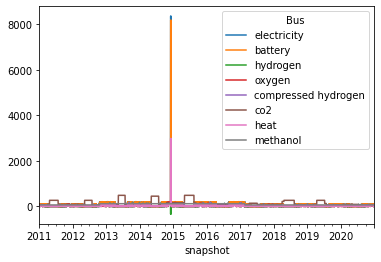

In [136]:
m.buses_t.marginal_price.plot()

<AxesSubplot: xlabel='snapshot'>

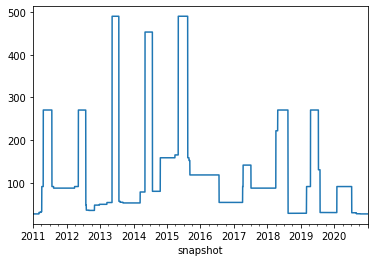

In [137]:
m.buses_t.marginal_price["co2"].plot()

<AxesSubplot: xlabel='snapshot'>

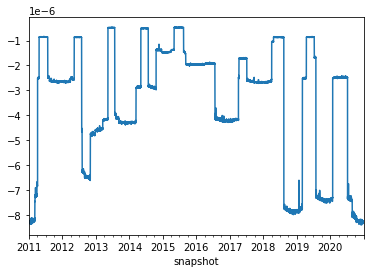

In [138]:
m.generators_t.p["co2 vent"].plot()

# Check for MeOH production

In [139]:
meoh_mv_meth = (m.buses_t.marginal_price["methanol"]*m.links_t.p1["methanol synthesis"]).sum()/m.links_t.p1["methanol synthesis"].sum()
meoh_mv_meth

88.95103037843327

In [140]:
h2_mv_meth = (m.buses_t.marginal_price["hydrogen"]*m.links_t.p0["methanol synthesis"]).sum()/m.links_t.p0["methanol synthesis"].sum()
h2_mv_meth

25.010330478091383

In [141]:
elec_mv_meth = (m.buses_t.marginal_price["electricity"]*m.links_t.p2["methanol synthesis"]).sum()/m.links_t.p2["methanol synthesis"].sum()
elec_mv_meth

14.289387209673984

In [142]:
co2_mv_meth = (m.buses_t.marginal_price["co2"]*m.links_t.p3["methanol synthesis"]).sum()/m.links_t.p3["methanol synthesis"].sum()
co2_mv_meth

162.9319476404592

In [143]:
#per MWh_MeOH contribution of synthesis
total_cost = (m.links.at["methanol synthesis","p_nom_opt"]*m.links.at["methanol synthesis","capital_cost"])
capex_part = total_cost/(-m.snapshot_weightings["generators"]*m.links_t.p1["methanol synthesis"]).sum()
capex_part

16.20946281727303

In [144]:
print(capex_part, h2_mv_meth/m.links.at["methanol synthesis","efficiency"], - co2_mv_meth*m.links.at["methanol synthesis","efficiency3"]/m.links.at["methanol synthesis","efficiency"],  - elec_mv_meth*m.links.at["methanol synthesis","efficiency2"]/m.links.at["methanol synthesis","efficiency"])
capex_part + h2_mv_meth/m.links.at["methanol synthesis","efficiency"] - co2_mv_meth*m.links.at["methanol synthesis","efficiency3"]/m.links.at["methanol synthesis","efficiency"]  - elec_mv_meth*m.links.at["methanol synthesis","efficiency2"]/m.links.at["methanol synthesis","efficiency"]

16.20946281727303 28.461358076424503 40.40851214941032 3.871693216255302


88.95102625936315

In [145]:
-m.links_t.p1["dac"].sum()*3*4

1029463.0294664365

In [146]:
m.links_t.p0["CCGT"].sum()*3

1037462.0526882748

# Check CCGT+DAC

In [147]:
m.links.loc["dac"]

bus0                        electricity
bus1                                co2
carrier                             dac
efficiency                     3.571429
p_nom_extendable                   True
capital_cost            25579696.332066
ramp_limit_up                       NaN
ramp_limit_down                     NaN
p_nom_opt                      1.219513
bus2                               heat
bus3                                   
efficiency2                   -5.357143
efficiency3                         1.0
type                                   
build_year                            0
lifetime                            inf
p_nom                               0.0
p_nom_min                           0.0
p_nom_max                           inf
p_set                               0.0
p_min_pu                            0.0
p_max_pu                            1.0
marginal_cost                       0.0
length                              0.0
terrain_factor                      1.0


In [151]:
# capacity factor
m.links_t.p0["dac"].mean()/m.links.at["dac","p_nom_opt"]

0.674002644986847

<AxesSubplot: xlabel='snapshot'>

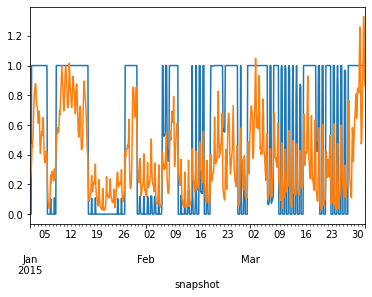

In [156]:
start = "2015-01"
end = "2015-03"

(m.links_t.p0["dac"]/m.links.at["dac","p_nom_opt"]).loc[start:end].plot()
m.generators_t.p_max_pu[["wind","solar"]].sum(axis=1).loc[start:end].plot()

In [100]:
co2_mv_meth = (m.buses_t.marginal_price["co2"]*m.links_t.p3["methanol synthesis"]).sum()/m.links_t.p3["methanol synthesis"].sum()
co2_mv_meth

108.91813065096642

In [101]:
elec_mv_dac = (m.buses_t.marginal_price["electricity"]*m.links_t.p0["dac"]).sum()/m.links_t.p0["dac"].sum()
elec_mv_dac

2.240622776374926

In [102]:
heat_mv_dac = (m.buses_t.marginal_price["heat"]*m.links_t.p2["dac"]).sum()/m.links_t.p2["dac"].sum()
heat_mv_dac

12.382004617785958

In [103]:
co2_mv_dac = (m.buses_t.marginal_price["co2"]*m.links_t.p1["dac"]).sum()/m.links_t.p1["dac"].sum()
co2_mv_dac

145.72548877193515

In [107]:
#per tCO2 contribution of DAC capex
total_cost = (m.links.at["dac","p_nom_opt"]*m.links.at["dac","capital_cost"])
capex_part = total_cost/(-m.links_t.p1["dac"]*m.snapshot_weightings["generators"]).sum()
capex_part

126.52592324946487

In [108]:
print(capex_part, elec_mv_dac/m.links.at["dac","efficiency"], - heat_mv_dac*m.links.at["dac","efficiency2"]/m.links.at["dac","efficiency"])
capex_part+ elec_mv_dac/m.links.at["dac","efficiency"] - heat_mv_dac*m.links.at["dac","efficiency2"]/m.links.at["dac","efficiency"]

126.52592324946487 0.6273743773849793 18.57300692667894


145.7263045535288

# How much demand is met directly by VRE?

In [113]:
ts = pd.concat([(-1)**i*m.links_t["p"+str(i)][m.links.index[m.links["bus"+str(i)].map(m.buses.carrier) == "electricity"]] for i in range(3)],
         axis=1)
ts["vre_direct"] = vre_direct = m.loads_t.p["load"] + m.links_t.p1[["battery_discharge","Allam"]].sum(axis=1)
ts["vre"] = m.generators_t.p[["wind","solar"]].sum(axis=1)
ts["load"] = m.loads_t.p["load"]
ts

Link,battery_power,hydrogen_electrolyser,heat pump,dac,battery_discharge,Allam,hydrogen_compressor,methanol synthesis,vre_direct,vre,load
snapshot,,,,,,,,,,,
2001-01-01 00:00:00,69.823309,5.199638e+01,2.105618e-07,1.061231e-07,0.005017,3.247090e-07,1.748857e+00,4.948917,99.994982,228.512436,100.0
2001-01-01 03:00:00,15.570315,5.199638e+01,2.102200e-07,1.059509e-07,0.004414,3.241183e-07,1.748858e+00,4.948917,99.995586,174.260046,100.0
2001-01-01 06:00:00,0.004385,5.199638e+01,2.099534e-07,1.058165e-07,8.104679,3.239940e-07,1.748848e+00,4.948917,91.895320,150.593840,100.0
2001-01-01 09:00:00,0.004383,5.199638e+01,2.098917e-07,1.057854e-07,6.965582,3.241064e-07,1.748848e+00,4.948917,93.034418,151.732936,100.0
2001-01-01 12:00:00,44.696654,5.199638e+01,2.099210e-07,1.058002e-07,0.004481,3.244604e-07,1.748858e+00,4.948917,99.995519,203.386318,100.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 09:00:00,0.000008,4.857567e-07,1.220436e-07,6.151000e-08,15.451320,2.844882e+01,3.153951e-07,2.474460,56.099856,58.574318,100.0
2020-12-31 12:00:00,20.784691,1.011300e+00,1.722492e-07,8.681358e-08,0.000022,4.838587e-07,9.248751e-07,2.474462,99.999977,124.270426,100.0
2020-12-31 15:00:00,0.000022,2.186811e-05,1.707130e-07,8.603933e-08,4.521480,4.929074e-07,8.883691e-07,2.474462,95.478520,97.953021,100.0


In [114]:
ts.describe()

Link,battery_power,hydrogen_electrolyser,heat pump,dac,battery_discharge,Allam,hydrogen_compressor,methanol synthesis,vre_direct,vre,load
count,5.844000e+04,5.844000e+04,5.844000e+04,5.844000e+04,5.844000e+04,5.844000e+04,5.844000e+04,58440.000000,58440.000000,58440.000000,58440.0
mean,1.604485e+01,2.494110e+01,2.087874e-07,1.052289e-07,1.540306e+01,8.942101e+00,5.468608e-01,4.038086,75.654840,121.225726,100.0
std,2.699073e+01,2.025026e+01,6.888412e-08,3.471760e-08,2.232379e+01,1.849172e+01,7.329610e-01,1.148375,30.992515,66.190382,0.0
min,2.652979e-08,1.009377e-09,7.573427e-10,3.817007e-10,2.613530e-08,1.269269e-07,1.192183e-09,2.474460,-3.178892,3.191535,100.0
25%,9.425541e-06,1.133901e+00,1.597250e-07,8.050142e-08,4.728296e-03,3.779795e-07,3.780677e-07,2.474460,48.610726,61.818110,100.0
50%,5.979922e-03,3.056512e+01,2.398601e-07,1.208895e-07,1.283269e-02,3.849011e-07,3.672492e-04,4.948919,99.931443,129.497151,100.0
75%,1.786321e+01,4.494896e+01,2.699284e-07,1.360439e-07,2.735281e+01,5.912926e+00,1.230285e+00,4.948920,99.995263,166.303741,100.0
max,8.264946e+01,5.199638e+01,3.827788e-07,1.929205e-07,8.264945e+01,7.103122e+01,2.405821e+00,4.948920,100.000000,241.345521,100.0


In [115]:
frac = ts.sum()/ts["load"].sum()
frac

Link
battery_power            1.604485e-01
hydrogen_electrolyser    2.494110e-01
heat pump                2.087874e-09
dac                      1.052289e-09
battery_discharge        1.540306e-01
Allam                    8.942101e-02
hydrogen_compressor      5.468608e-03
methanol synthesis       4.038086e-02
vre_direct               7.565484e-01
vre                      1.212257e+00
load                     1.000000e+00
dtype: float64

In [116]:
mvs = ts.multiply(m.buses_t.marginal_price["electricity"],axis=0).sum()/ts.sum()
mvs

Link
battery_power             31.834536
hydrogen_electrolyser     16.775115
heat pump                 37.833985
dac                       37.833985
battery_discharge        106.218415
Allam                    345.122136
hydrogen_compressor        8.608983
methanol synthesis        59.576749
vre_direct                51.840602
vre                       42.040960
load                      86.441979
dtype: float64

In [117]:
gens = ['vre_direct', 'battery_discharge', 'Allam']
frac[gens].sum()

1.0

In [118]:
(frac[gens]*mvs[gens]).sum()

86.44197914707084

In [119]:
gen_frac = ts.sum()/ts["vre"].sum()
gen_frac

Link
battery_power            1.323552e-01
hydrogen_electrolyser    2.057410e-01
heat pump                1.722303e-09
dac                      8.680406e-10
battery_discharge        1.270610e-01
Allam                    7.376405e-02
hydrogen_compressor      4.511096e-03
methanol synthesis       3.331047e-02
vre_direct               6.240824e-01
vre                      1.000000e+00
load                     8.249074e-01
dtype: float64

In [121]:
chargers= ['battery_power', 'hydrogen_electrolyser', 'hydrogen_compressor',"dac","heat pump","methanol synthesis"]

(gen_frac[chargers]*mvs[chargers]).sum() + gen_frac["vre_direct"]*mvs["vre_direct"]


42.040965700245934

In [76]:
stats = n.statistics().groupby(level=1).sum()
stats

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
battery discharger,0.360707,0.000000e+00,0.000000,0.0,0.000000,39.405178,11.596551,13.926531,-14.213706
battery inverter,0.375736,9.067038e+06,0.000000,0.0,0.000000,38.609036,90.374896,14.213705,-14.506801
battery storage,0.504361,3.450641e+07,0.000000,0.0,0.000000,310.160385,393.068260,8.535403,-8.535403
hydrogen,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
hydrogen electrolyser,0.387648,3.855470e+07,0.000000,0.0,0.000000,91.246048,438.964363,24.052546,-35.371391
hydrogen storage,0.549065,7.500729e+07,0.000000,0.0,0.000000,67669.910061,861.569536,23.437873,-23.437873
hydrogen storing compressor,0.416868,7.419229e+06,0.000000,0.0,0.000000,62.048115,126.576723,25.865875,-25.865875
hydrogen storing decompressor,0.180010,0.000000e+00,0.000000,0.0,0.000000,143.691255,-0.294532,25.865875,-25.865875
hydrogen turbine,0.178517,7.480198e+07,0.000000,0.0,0.000000,134.735292,852.386716,13.950477,-24.052547


In [77]:
vre = stats.loc[["wind","solar"],"Supply"].sum()
vre

125.10509098467267

In [78]:
n.links.at["hydrogen_compressor","efficiency2"]

-0.12000012000011999

In [79]:
storage_load = -stats.loc[["battery inverter","hydrogen electrolyser"],"Withdrawal"].sum() + n.links.at["hydrogen_compressor","efficiency2"]*stats.at["hydrogen storing compressor","Withdrawal"]
storage_load

52.98210016555471

In [80]:
vre - storage_load

72.12299081911796

In [81]:
storage_supply = stats.loc[["battery discharger","hydrogen turbine"],"Supply"]
storage_supply.sum(),storage_supply

(27.8770079967613,
 carrier
 battery discharger    13.926531
 hydrogen turbine      13.950477
 Name: Supply, dtype: float64)

In [82]:
vre - storage_load + storage_supply.sum()

99.99999881587925

<AxesSubplot: xlabel='snapshot'>

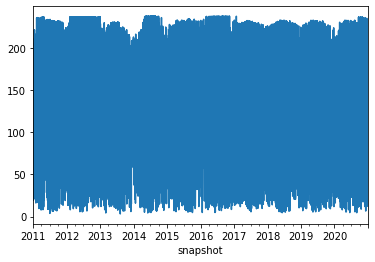

In [83]:
vre_s = n.generators_t.p[["wind","solar"]].sum(axis=1)
vre_s.plot()

In [84]:
df = pd.DataFrame(index=n.snapshots)
df["vre"] = vre_s
df["load"] = n.loads_t.p["load"]
df.mean()

vre     125.105091
load    100.000000
dtype: float64

<AxesSubplot: xlabel='snapshot'>

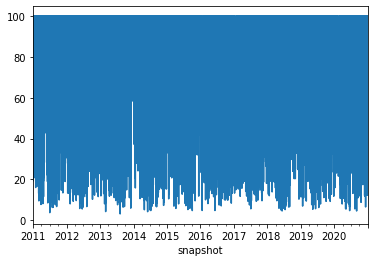

In [88]:
#this definition is different to above since batteries can charge electrolyser etc.
vre_direct = df.min(axis=1)
vre_direct.plot()

In [86]:
vre_direct.mean()

80.29315574371539

<AxesSubplot: xlabel='snapshot'>

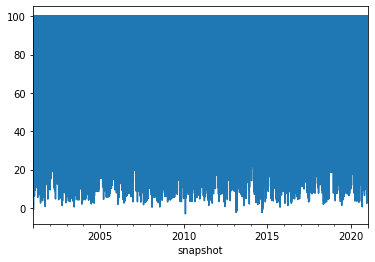

In [87]:
ts["vre_direct"].plot()

In [89]:
ts["vre_direct"].mean()

75.65483982691327

# calculate balances

In [334]:
inel = pypsa.Network("networks/230410-20a-UK-inelastic-fixed/UK-20a-H2u-inelastic.nc")
el = pypsa.Network("networks/230410-20a-UK-inelastic-fixed/UK-20a-H2u.nc")

INFO:pypsa.io:Imported network UK-20a-H2u-inelastic.nc has buses, generators, links, stores
INFO:pypsa.io:Imported network UK-20a-H2u.nc has buses, generators, links, loads, stores


In [329]:
def calculate_balances(n):
    
    balances = pd.Series()

    bus_carriers = n.buses.carrier.unique()

    for i in bus_carriers:
        bus_map = (n.buses.carrier == i)
        bus_map.at[""] = False

        for c in n.iterate_components(n.one_port_components):

            items = c.df.index[c.df.bus.map(bus_map).fillna(False)]
            if len(items) == 0:
                continue

            s = c.pnl.p[items].multiply(n.snapshot_weightings.generators,axis=0).sum().multiply(c.df.loc[items, 'sign']).groupby(c.df.loc[items, 'carrier']).sum()
            s = pd.concat([s], keys=[i])
            balances = balances.reindex(s.index.union(balances.index))
            balances.loc[s.index] = s

        for c in n.iterate_components(n.branch_components):

            for end in [col[3:] for col in c.df.columns if col[:3] == "bus"]:

                items = c.df.index[c.df["bus" + str(end)].map(bus_map, na_action=False)]

                if len(items) == 0:
                    continue

                s = (-1)*c.pnl["p"+end][items].multiply(n.snapshot_weightings.generators,axis=0).sum().groupby(c.df.loc[items, 'carrier']).sum()
                s.index = s.index + end
                s = pd.concat([s], keys=[i])
                balances = balances.reindex(s.index.union(balances.index))
                balances.loc[s.index] = s
    return balances

In [330]:
balances = calculate_balances(n)
balances

<ipython-input-329-dbfe400e6da0>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  balances = pd.Series()


battery              battery discharger0              -1.144549e+06
                     battery inverter1                 1.144549e+06
                     battery storage                  -8.043344e-12
compressed hydrogen  hydrogen storage                 -9.094947e-12
                     hydrogen storing compressor1      3.582781e+06
                     hydrogen storing decompressor0   -3.582781e+06
electricity          battery discharger1               1.121424e+06
                     battery inverter0                -1.168150e+06
                     hydrogen electrolyser0           -5.221619e+06
                     hydrogen storing compressor2     -4.299342e+05
                     hydrogen turbine1                 2.059406e+06
                     load                             -1.752153e+07
                     solar                             6.736925e+06
                     wind                              1.442348e+07
hydrogen             hydrogen electrolyser1     

In [331]:
n.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,


<AxesSubplot: xlabel='snapshot'>

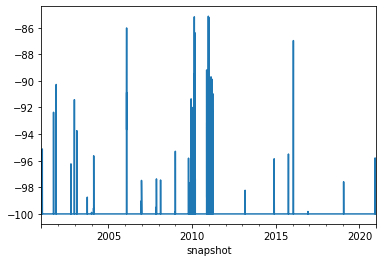

In [333]:
n.generators_t.p["load"].plot()

In [335]:
inel = pypsa.Network("networks/230410-20a-UK-inelastic-fixed/UK-20a-H2u-inelastic.nc")
el = pypsa.Network("networks/230410-20a-UK-inelastic-fixed/UK-20a-H2u.nc")

INFO:pypsa.io:Imported network UK-20a-H2u-inelastic.nc has buses, generators, links, stores
INFO:pypsa.io:Imported network UK-20a-H2u.nc has buses, generators, links, loads, stores


In [342]:
(100+inel.generators_t.p["load"].mean())/100

0.000596981657830753

<AxesSubplot: xlabel='snapshot'>

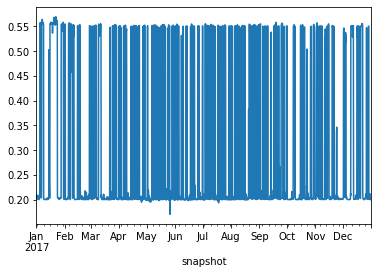

In [352]:
el.buses_t.marginal_price["electricity"].loc["2017"].plot()

<AxesSubplot: xlabel='snapshot'>

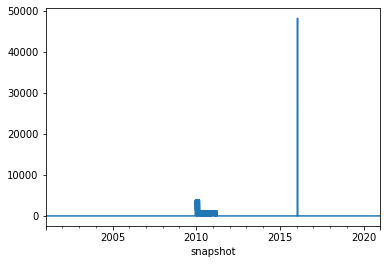

In [340]:
el.buses_t.marginal_price["electricity"].plot()

In [347]:
for year in range(2001,2021):
    print(year,inel.buses_t.marginal_price["electricity"].loc[str(year)].mean())

2001 28.97105058113951
2002 137.6669394520763
2003 19.49773411345628
2004 13.058731939562845
2005 8.136863595373338
2006 53.849959531998536
2007 8.941070673218736
2008 21.91683668751286
2009 112.74475799819717
2010 826.5533663725835
2011 305.7449812776099
2012 0.33310136008598434
2013 3.9047394141811163
2014 13.847988759476259
2015 7.5027176794029025
2016 16.735939129386594
2017 0.3100187529862477
2018 0.3231303124558135
2019 4.631685527834868
2020 5.330265832631398


In [348]:
for year in range(2001,2021):
    print(year,el.buses_t.marginal_price["electricity"].loc[str(year)].mean())

2001 0.3305102254069614
2002 1.2174542626368992
2003 0.33316336889942294
2004 0.32167948436610766
2005 0.31160890797344115
2006 0.338779101970587
2007 0.3124216016792246
2008 0.31322455695654017
2009 178.67428558190036
2010 1026.0714692248935
2011 172.49179963835766
2012 0.3329763368732172
2013 0.31040268007323885
2014 0.3332935545064165
2015 0.3142120876575524
2016 218.25092406101584
2017 0.31074739485911224
2018 0.32272880716164426
2019 0.3178564312353397
2020 0.3113269834246511


In [349]:
el.buses_t.marginal_price["electricity"].mean()

80.0512861872611

In [350]:
inel.buses_t.marginal_price["electricity"].mean()

79.45353329318671